1. 데이터 처리와 분류
라벨 데이터 처리하기
sklearn의 train_test_split함수를 이용하여 train, test 분리

$ mkdir -p ~/aiffel/speech_recognition/data
$ mkdir -p ~/aiffel/speech_recognition/models
$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data

In [1]:
#Data SET
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [2]:
#Data check
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)


Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
#Data label

import IPython.display as ipd
import random

rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)


rand num :  34104
Wave data shape :  (8000,)
label :  ['right']


In [4]:
#Label data processing

target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
   new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)


LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
#txt label data >> index
temp = []
for v in speech_data["label_vals"]:
   temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data


array([ 3,  3,  3, ..., 11, 11, 11])

In [6]:
#split the data

from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"],
                                                               label_data,
                                                               test_size=0.1,
                                                               shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])


[[ 3.9077783e-03  6.4756428e-03  3.4024862e-03 ... -7.1606133e-04
  -1.6418654e-03 -4.9136630e-03]
 [ 4.8200754e-03  6.6878451e-03  1.8385899e-03 ...  5.0121378e-03
   7.3261848e-03  8.3823288e-03]
 [ 6.4754677e-05  5.9785783e-05  1.4532113e-04 ...  4.1011139e-05
   3.6084562e-05 -6.9441558e-05]
 ...
 [ 3.1702365e-03  4.6540918e-03  5.3446242e-03 ...  4.0515081e-04
   6.7125930e-04 -1.5180149e-04]
 [-7.3786650e-05 -6.9957765e-05  2.4861071e-04 ... -1.7949380e-05
  -2.2973256e-04 -5.0410361e-04]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.1576081e-05
  -2.7667937e-05 -4.0940497e-05]]


In [7]:
#splited data check
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")


train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


2. 학습을 위한 하이퍼파라미터 설정

In [8]:
#hyper-parameter setting

batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir


'/home/ssac9/aiffel/speech_recognition/models/wav'

In [9]:
#data setting
def one_hot_label(wav, label):
   label = tf.one_hot(label, depth=12)
   return wav, label
print("✅")


✅


3. 데이터셋 구성
tf.data.Dataset을 이용
from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
map과 batch를 이용한 데이터 전처리
주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.
del speech_data
del spec_data


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")


<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅



4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
batchnorm, dropout, dense layer 등을 이용
12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
모델 가중치를 저장하는 checkpoint callback 함수 추가
다양한 모델의 실험을 진행해 보시기 바랍니다.

$ pip install librosa

In [11]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
   D = np.abs(librosa.stft(wav, n_fft=fft_size))
   return D
print("✅")


✅


In [12]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)


Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


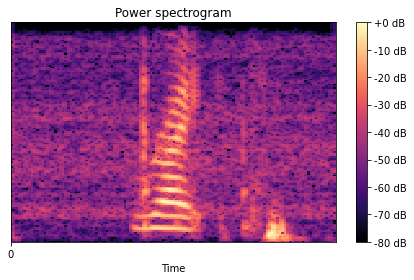

In [13]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()


#Conv1D layer를 이용해서 모델을 구성

In [14]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

#adam optimizer

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            optimizer=optimizer,
            metrics=['accuracy'])
print("✅")


✅


#training

In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='auto',
                                                save_best_only=True,
                                                verbose=1)
print("✅")


✅


In [ ]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                   steps_per_epoch=len(train_wav) // batch_size,
                   validation_data=test_dataset,
                   validation_steps=len(test_wav) // batch_size,
                   callbacks=[cp_callback]
                   )
print("✅")


Epoch 1/10
  32/1423 [..............................] - ETA: 37:39 - loss: 2.4399 - accuracy: 0.1318


5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
loss, accuracy를 그래프로 표현


In [ ]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")


6. Test dataset을 이용해서 모델의 성능을 평가
저장한 weight 불러오기
모델의 예측값과 정답값이 얼마나 일치하는지 확인


In [ ]:
model_wav.load_weights(checkpoint_dir)
print("✅")

results = model_wav.evaluate(test_dataset)
print("✅")

# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")


In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)


In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
   print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
   print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")


 
평가문항
상세기준
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.
evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.
